# MAll Customer Segmentation Using Unsupervised Learning 

## 1.Introduction

### 1.1 Problem Statement 
Customer segmentation is a crucial task for businesses to understand their customer base and develop targeted marketing strategies. In this project,we aim to segment mall customers based on their annual income and spending behavior.

### 1.2 Dataset 
- Source: Kaggle Mall Customer Segmentation Data
- Size: 200 customers, 5 features
- Features: CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)

### 1.3 Objective
Compare 4 different clustering algorithms:
1. K-Means Clustering
2. DBSCAN (Density-Based Spatial Clustering)
3. Gaussian Mixture Model (GMM)
4. Hierarchical Clustering

### 1.4 Evaluation Metrics
- Silhouette Score
- Visual inspection of cluster separation
- Business interpretability

## 2. Import Libraries & Load Data

### 2.1 Import libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Evaluation metrics
from sklearn.metrics import silhouette_score, silhouette_samples

# Hierarchical clustering visualization
from scipy.cluster.hierarchy import dendrogram, linkage

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')  # Clean plot style



### 2.2 Load Dataset

In [2]:

# Load the data
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

# First look at the data
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)

print(f"\nShape: {df.shape[0]} rows, {df.shape[1]} columns")

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Statistical Summary ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Duplicate Rows ---")
print(f"Number of duplicates: {df.duplicated().sum()}")

DATASET OVERVIEW

Shape: 200 rows, 5 columns

--- First 5 Rows ---
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

--- Data Types ---
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

--- Statistical Summary ---
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721        

## 3. Exploratory Data Analysis (EDA)


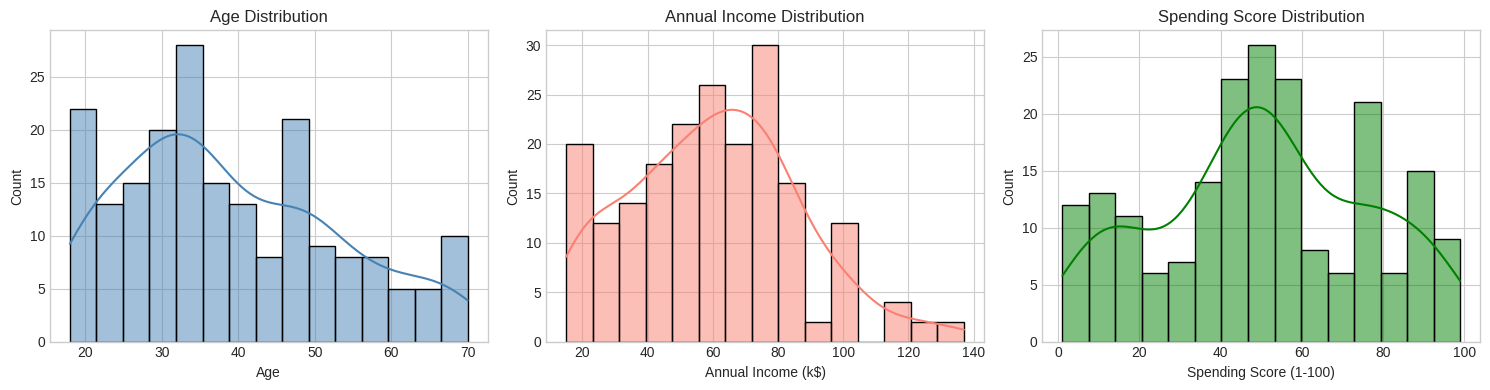


Observation:
- Age: Majority of customers are between 25-45 years old
- Annual Income: Fairly uniform distribution, ranging from 15k to 137k
- Spending Score: Relatively uniform, slight peaks at both ends


In [3]:
# 3.1 Distribution of Numerical Feature 
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Age distribution
sns.histplot(df['Age'], kde=True, ax=axes[0], color='steelblue', bins=15)
axes[0].set_title('Age Distribution', fontsize=12)
axes[0].set_xlabel('Age')

# Annual Income distribution
sns.histplot(df['Annual Income (k$)'], kde=True, ax=axes[1], color='salmon', bins=15)
axes[1].set_title('Annual Income Distribution', fontsize=12)
axes[1].set_xlabel('Annual Income (k$)')

# Spending Score distribution
sns.histplot(df['Spending Score (1-100)'], kde=True, ax=axes[2], color='green', bins=15)
axes[2].set_title('Spending Score Distribution', fontsize=12)
axes[2].set_xlabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Age: Majority of customers are between 25-45 years old")
print("- Annual Income: Fairly uniform distribution, ranging from 15k to 137k")
print("- Spending Score: Relatively uniform, slight peaks at both ends")

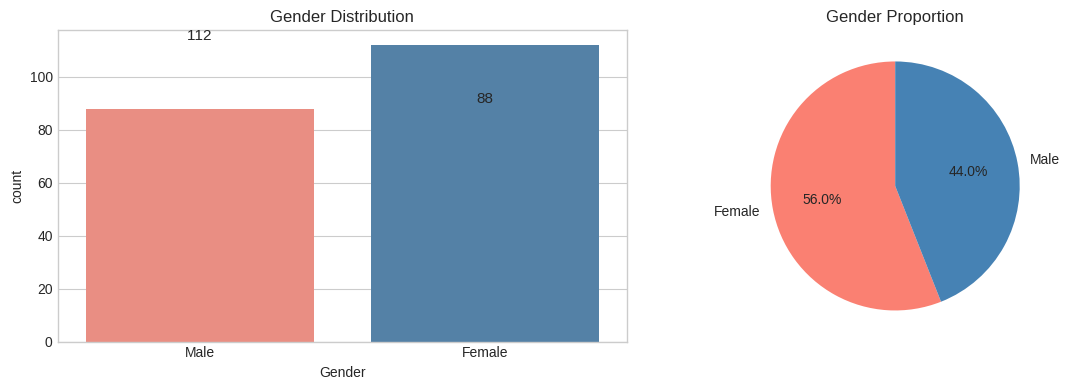


Gender breakdown:
- Female: 112 (56.0%)
- Male: 88 (44.0%)


In [4]:
# 3.2 Gender Distribution
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
gender_counts = df['Gender'].value_counts()
sns.countplot(x='Gender', data=df, ax=axes[0], palette=['salmon', 'steelblue'])
axes[0].set_title('Gender Distribution', fontsize=12)

# Add count labels on bars
for i, count in enumerate(gender_counts):
    axes[0].text(i, count + 2, str(count), ha='center', fontsize=11)

# Pie chart
axes[1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', 
            colors=['salmon', 'steelblue'], startangle=90)
axes[1].set_title('Gender Proportion', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nGender breakdown:")
print(f"- Female: {gender_counts['Female']} ({gender_counts['Female']/len(df)*100:.1f}%)")
print(f"- Male: {gender_counts['Male']} ({gender_counts['Male']/len(df)*100:.1f}%)")

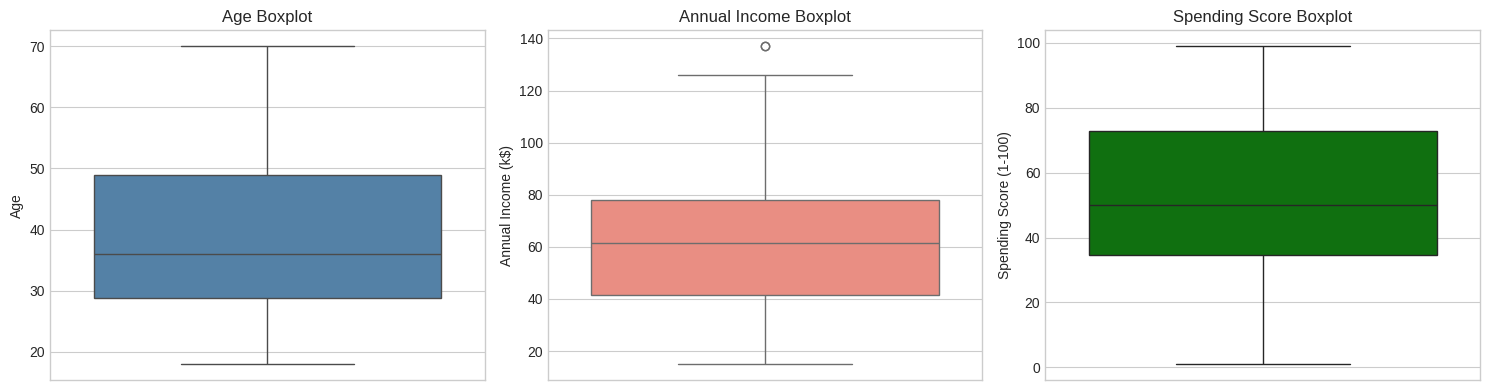


Outlier Analysis:
- Age: No significant outliers
- Annual Income: No significant outliers
- Spending Score: No outliers detected
- Conclusion: Data is clean, no outlier treatment needed


In [5]:
# 3.3 Boxplots - Check for Outliers
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(y=df['Age'], ax=axes[0], color='steelblue')
axes[0].set_title('Age Boxplot', fontsize=12)

sns.boxplot(y=df['Annual Income (k$)'], ax=axes[1], color='salmon')
axes[1].set_title('Annual Income Boxplot', fontsize=12)

sns.boxplot(y=df['Spending Score (1-100)'], ax=axes[2], color='green')
axes[2].set_title('Spending Score Boxplot', fontsize=12)

plt.tight_layout()
plt.show()

print("\nOutlier Analysis:")
print("- Age: No significant outliers")
print("- Annual Income: No significant outliers")
print("- Spending Score: No outliers detected")
print("- Conclusion: Data is clean, no outlier treatment needed")

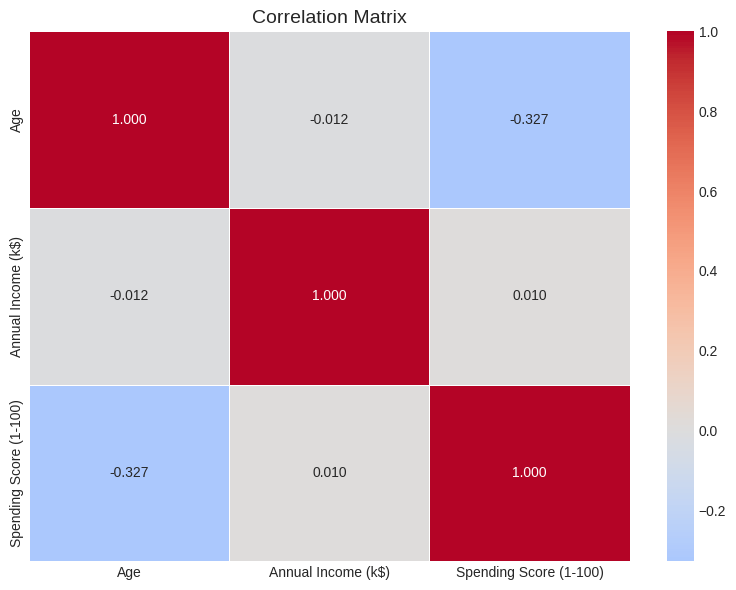


Correlation Insights:
- Age vs Annual Income: Very weak correlation (0.009)
- Age vs Spending Score: Weak negative correlation (-0.327)
- Annual Income vs Spending Score: Almost no correlation (0.010)
- Features are largely independent, good for clustering


In [6]:
# 3.4 Correlation Analysis
# -----------------------------------------------------------------------------

# Select only numerical columns (exclude CustomerID)
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
print("- Age vs Annual Income: Very weak correlation (0.009)")
print("- Age vs Spending Score: Weak negative correlation (-0.327)")
print("- Annual Income vs Spending Score: Almost no correlation (0.010)")
print("- Features are largely independent, good for clustering")

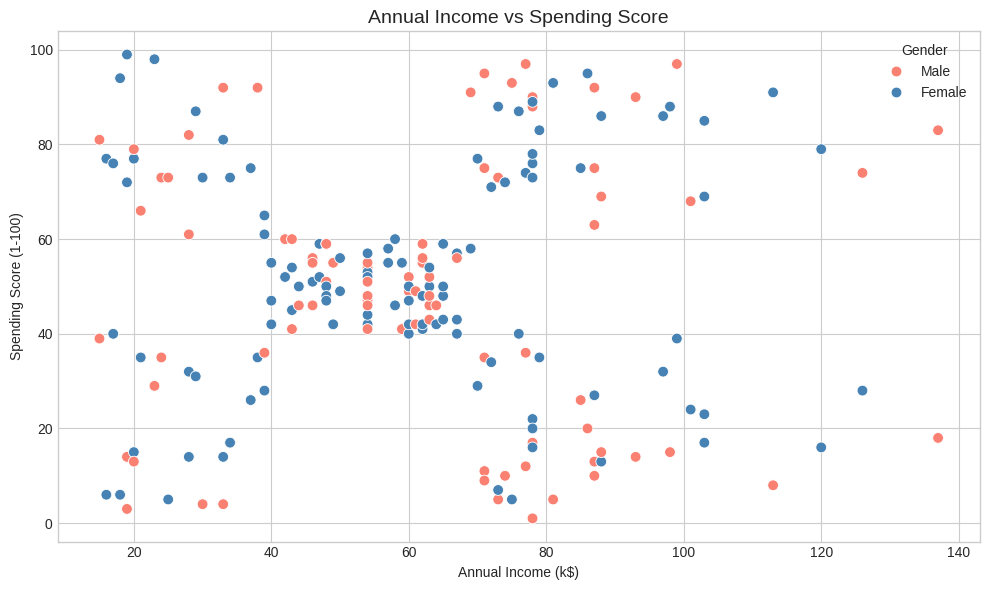


Key Observation:
- Visual inspection suggests ~5 natural clusters
- Gender does not appear to be a strong differentiator
- We will use 'Annual Income' and 'Spending Score' as clustering features


In [7]:
# 3.5 Key Relationship: Annual Income vs Spending Score
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Gender', data=df, palette=['salmon', 'steelblue'], s=60)
plt.title('Annual Income vs Spending Score', fontsize=14)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

print("\nKey Observation:")
print("- Visual inspection suggests ~5 natural clusters")
print("- Gender does not appear to be a strong differentiator")
print("- We will use 'Annual Income' and 'Spending Score' as clustering features")

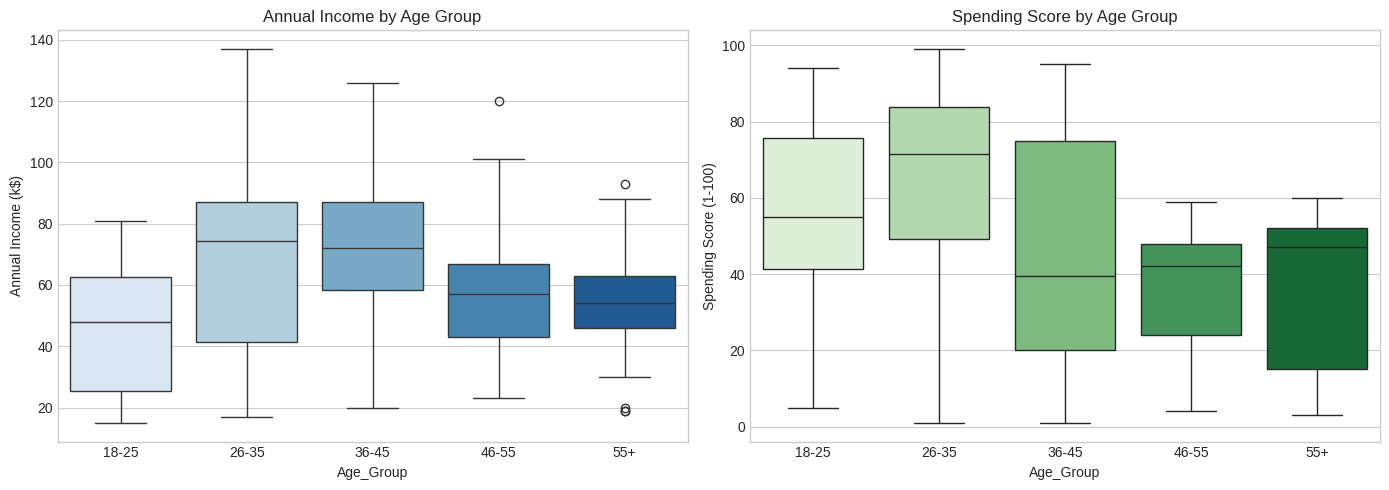


Age Group Insights:
- Income is relatively stable across age groups
- Younger customers (18-25) tend to have slightly higher spending scores
- Spending score decreases with age


In [8]:
# 3.6 Age Group Analysis
# -----------------------------------------------------------------------------

# Create age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], 
                         labels=['18-25', '26-35', '36-45', '46-55', '55+'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Income by age group
sns.boxplot(x='Age_Group', y='Annual Income (k$)', data=df, ax=axes[0], palette='Blues')
axes[0].set_title('Annual Income by Age Group', fontsize=12)

# Spending score by age group
sns.boxplot(x='Age_Group', y='Spending Score (1-100)', data=df, ax=axes[1], palette='Greens')
axes[1].set_title('Spending Score by Age Group', fontsize=12)

plt.tight_layout()
plt.show()

# Remove the temporary column
df.drop('Age_Group', axis=1, inplace=True)

print("\nAge Group Insights:")
print("- Income is relatively stable across age groups")
print("- Younger customers (18-25) tend to have slightly higher spending scores")
print("- Spending score decreases with age")


## 4.DATA PREPROCESSING

In [9]:
# 4.1 Feature Selection
# -----------------------------------------------------------------------------
"""
Why choose 'Annual Income' and 'Spending Score' for clustering?

1. Business Relevance: These two features directly reflect customer value
   - Income: Customer's purchasing power
   - Spending Score: Customer's actual spending behavior
   
2. From EDA: The scatter plot shows clear visual clusters with these features

3. CustomerID: Just an identifier, not useful for clustering

4. Gender: From EDA, gender doesn't show strong differentiation in spending patterns

5. Age: Weak correlation with other features, can be used for post-analysis
"""

# Select features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

print("Selected Features for Clustering:")
print(X.head(10))
print(f"\nShape: {X.shape}")

Selected Features for Clustering:
   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40
5                  17                      76
6                  18                       6
7                  18                      94
8                  19                       3
9                  19                      72

Shape: (200, 2)


In [10]:
# 4.2 Feature Scaling
# -----------------------------------------------------------------------------
"""
Why do we need scaling?

1. K-Means uses Euclidean distance - sensitive to feature scales
2. Annual Income ranges from 15-137, Spending Score ranges from 1-99
3. Without scaling, Income would dominate the distance calculation
4. StandardScaler: transforms data to have mean=0 and std=1
"""

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame for better visualization
X_scaled_df = pd.DataFrame(X_scaled, columns=['Annual Income (scaled)', 'Spending Score (scaled)'])

print("After Scaling:")
print(X_scaled_df.head(10))
print(f"\nMean of scaled features:\n{X_scaled_df.mean()}")
print(f"\nStd of scaled features:\n{X_scaled_df.std()}")

After Scaling:
   Annual Income (scaled)  Spending Score (scaled)
0               -1.738999                -0.434801
1               -1.738999                 1.195704
2               -1.700830                -1.715913
3               -1.700830                 1.040418
4               -1.662660                -0.395980
5               -1.662660                 1.001596
6               -1.624491                -1.715913
7               -1.624491                 1.700384
8               -1.586321                -1.832378
9               -1.586321                 0.846310

Mean of scaled features:
Annual Income (scaled)    -2.131628e-16
Spending Score (scaled)   -1.465494e-16
dtype: float64

Std of scaled features:
Annual Income (scaled)     1.002509
Spending Score (scaled)    1.002509
dtype: float64


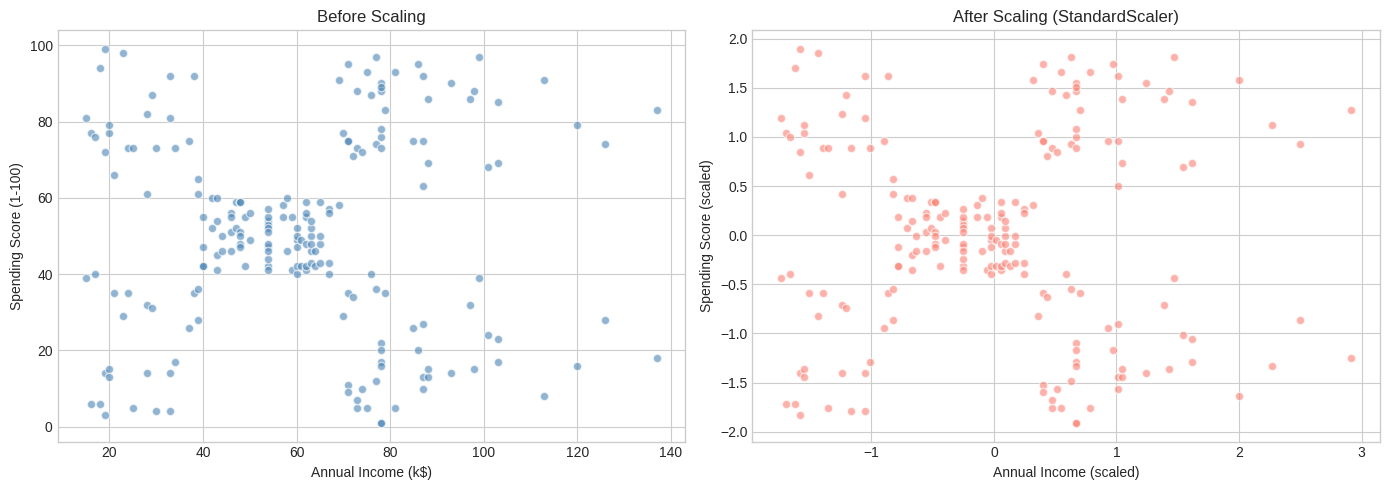


Note: The shape/pattern of data remains the same after scaling
Only the scale of axes changes (now centered around 0)


In [11]:
# 4.3 Visualize Before vs After Scaling
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], 
                c='steelblue', alpha=0.6, edgecolors='white')
axes[0].set_title('Before Scaling', fontsize=12)
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')

# After scaling
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], 
                c='salmon', alpha=0.6, edgecolors='white')
axes[1].set_title('After Scaling (StandardScaler)', fontsize=12)
axes[1].set_xlabel('Annual Income (scaled)')
axes[1].set_ylabel('Spending Score (scaled)')

plt.tight_layout()
plt.show()

print("\nNote: The shape/pattern of data remains the same after scaling")
print("Only the scale of axes changes (now centered around 0)")

## 5. CLUSTERING MODELS

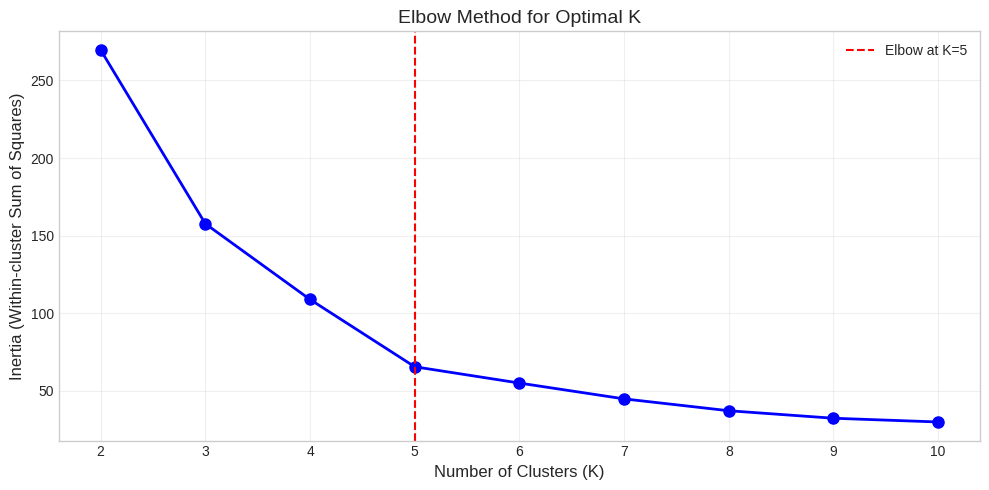

Elbow Method Analysis:
- Inertia decreases as K increases
- The 'elbow' point is where the rate of decrease sharply changes
- Optimal K appears to be around 5


In [12]:
# 5.1 K-Means Clustering
# 5.1.1 Elbow Method - Find Optimal K

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)

# Mark the elbow point
plt.axvline(x=5, color='red', linestyle='--', label='Elbow at K=5')
plt.legend()
plt.tight_layout()
plt.show()

print("Elbow Method Analysis:")
print("- Inertia decreases as K increases")
print("- The 'elbow' point is where the rate of decrease sharply changes")
print("- Optimal K appears to be around 5")

K=2: Silhouette Score = 0.3213
K=3: Silhouette Score = 0.4666
K=4: Silhouette Score = 0.4939
K=5: Silhouette Score = 0.5547
K=6: Silhouette Score = 0.5399
K=7: Silhouette Score = 0.5281
K=8: Silhouette Score = 0.4552
K=9: Silhouette Score = 0.4571
K=10: Silhouette Score = 0.4432


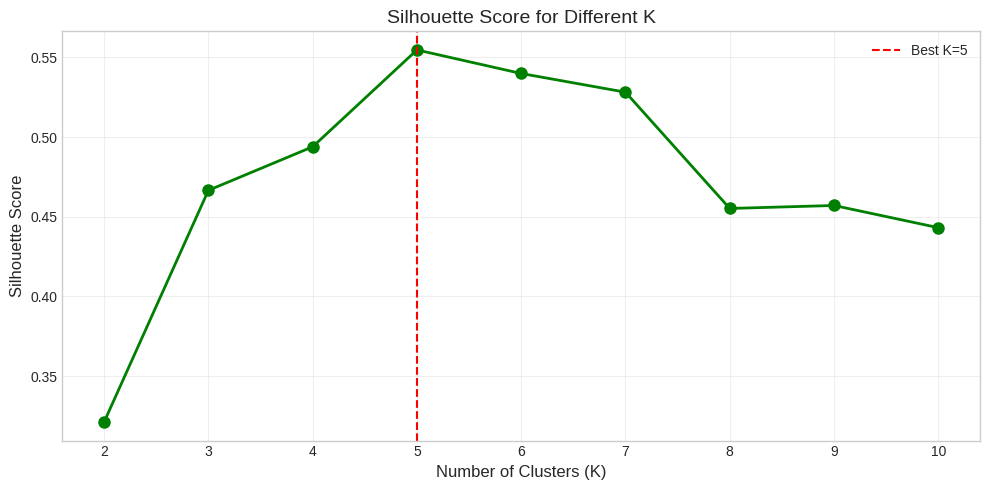


Best K based on Silhouette Score: 5
Highest Silhouette Score: 0.5547


In [13]:
# 5.1.2 Silhouette Score for Different K
# -----------------------------------------------------------------------------

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Different K', fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)

# Mark the best K
best_k = K_range[np.argmax(silhouette_scores)]
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K={best_k}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest K based on Silhouette Score: {best_k}")
print(f"Highest Silhouette Score: {max(silhouette_scores):.4f}")

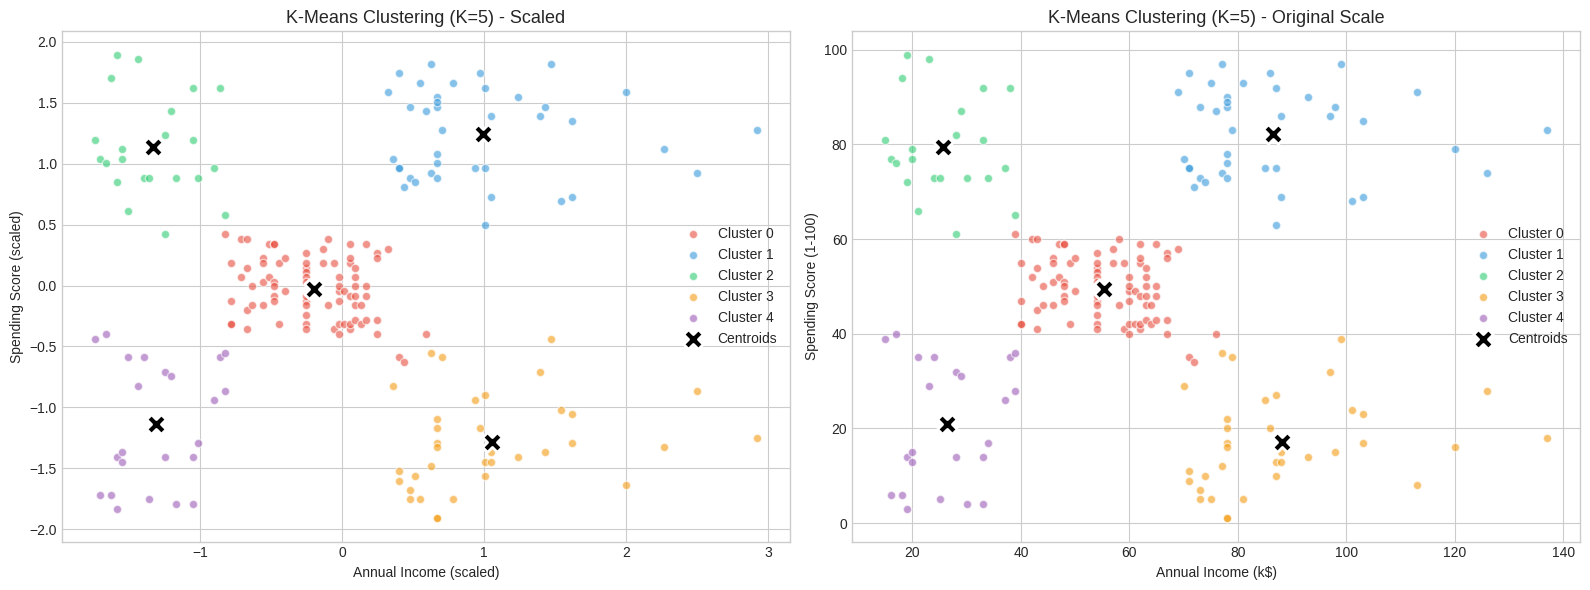


K-Means Cluster Summary:
Cluster 0: n=81, Avg Income=55.3k, Avg Spending=49.5
Cluster 1: n=39, Avg Income=86.5k, Avg Spending=82.1
Cluster 2: n=22, Avg Income=25.7k, Avg Spending=79.4
Cluster 3: n=35, Avg Income=88.2k, Avg Spending=17.1
Cluster 4: n=23, Avg Income=26.3k, Avg Spending=20.9


In [14]:
# 5.1.3 Final K-Means Model (K=5)
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Get cluster centers (in original scale for interpretation)
centers_scaled = kmeans_final.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

# Visualize K-Means Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Clusters on scaled data
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
for i in range(5):
    mask = kmeans_labels == i
    axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolors='white')
axes[0].scatter(centers_scaled[:, 0], centers_scaled[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2,
                label='Centroids')
axes[0].set_title('K-Means Clustering (K=5) - Scaled', fontsize=13)
axes[0].set_xlabel('Annual Income (scaled)')
axes[0].set_ylabel('Spending Score (scaled)')
axes[0].legend()

# Plot 2: Clusters on original data (more interpretable)
for i in range(5):
    mask = kmeans_labels == i
    axes[1].scatter(X.iloc[mask, 0], X.iloc[mask, 1],
                    c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolors='white')
axes[1].scatter(centers_original[:, 0], centers_original[:, 1],
                c='black', marker='X', s=200, edgecolors='white', linewidths=2,
                label='Centroids')
axes[1].set_title('K-Means Clustering (K=5) - Original Scale', fontsize=13)
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print cluster summary
print("\nK-Means Cluster Summary:")
print("="*60)
for i in range(5):
    mask = kmeans_labels == i
    count = mask.sum()
    avg_income = X.iloc[mask, 0].mean()
    avg_spending = X.iloc[mask, 1].mean()
    print(f"Cluster {i}: n={count}, Avg Income={avg_income:.1f}k, Avg Spending={avg_spending:.1f}")

In [15]:
# 5.2.1 Parameter Tuning - Grid Search for best eps and min_samples
from itertools import product

eps_range = np.arange(0.3, 0.8, 0.05)
min_samples_range = [3, 4, 5, 6, 7]

best_score = -1
best_params = {}
results = []

print("DBSCAN Parameter Grid Search:")
print("="*65)
print(f"{'eps':>6} | {'min_samples':>11} | {'n_clusters':>10} | {'noise_pts':>9} | {'silhouette':>10}")
print("-"*65)

for eps, min_s in product(eps_range, min_samples_range):
    dbscan = DBSCAN(eps=eps, min_samples=min_s)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    
    if n_clusters >= 2:
        # Only compute silhouette for non-noise points
        mask = labels != -1
        if mask.sum() > n_clusters:
            score = silhouette_score(X_scaled[mask], labels[mask])
            results.append({'eps': eps, 'min_samples': min_s, 
                          'n_clusters': n_clusters, 'noise': n_noise, 'score': score})
            print(f"{eps:>6.2f} | {min_s:>11} | {n_clusters:>10} | {n_noise:>9} | {score:>10.4f}")
            
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_s}

print(f"\nBest Parameters: eps={best_params['eps']:.2f}, min_samples={best_params['min_samples']}")
print(f"Best Silhouette Score: {best_score:.4f}")

DBSCAN Parameter Grid Search:
   eps | min_samples | n_clusters | noise_pts | silhouette
-----------------------------------------------------------------
  0.30 |           3 |          9 |        14 |     0.4720
  0.30 |           4 |          8 |        23 |     0.5197
  0.30 |           5 |          7 |        35 |     0.5243
  0.30 |           6 |          6 |        48 |     0.5302
  0.30 |           7 |          4 |        72 |     0.6452
  0.35 |           3 |          7 |        11 |     0.5154
  0.35 |           4 |          7 |        16 |     0.5110
  0.35 |           5 |          6 |        23 |     0.5577
  0.35 |           6 |          7 |        25 |     0.5031
  0.35 |           7 |          5 |        47 |     0.5708
  0.40 |           3 |          4 |        10 |     0.3954
  0.40 |           4 |          3 |        14 |     0.4576
  0.40 |           5 |          4 |        15 |     0.4781
  0.40 |           6 |          4 |        19 |     0.4900
  0.40 |           

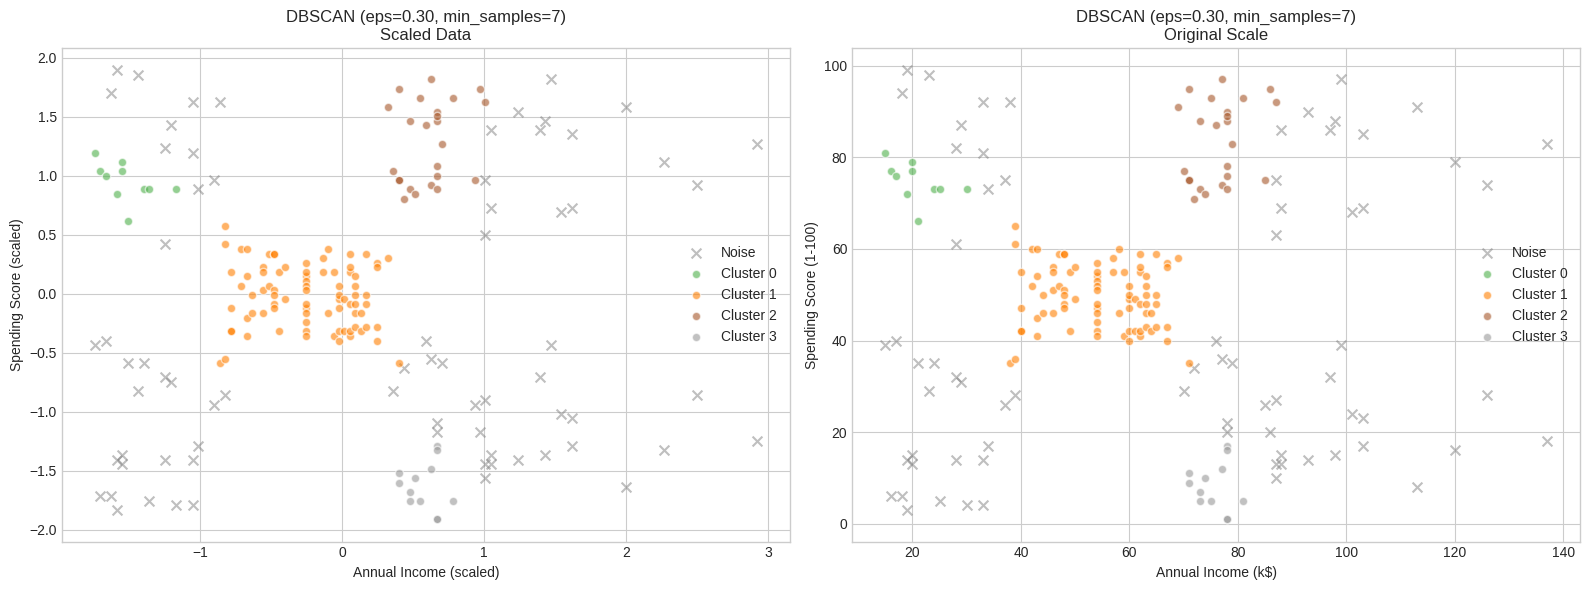


DBSCAN Results:
- Number of clusters: 4
- Noise points: 72 (36.0%)
- Silhouette Score (non-noise): 0.6452

Note: DBSCAN found 4 clusters but labeled 72 points as noise.
The high noise ratio suggests this dataset has overlapping cluster boundaries,
which DBSCAN struggles with compared to K-Means.


In [16]:
# 5.2.2 Final DBSCAN Model
dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels = dbscan_final.fit_predict(X_scaled)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = (dbscan_labels == -1).sum()

# Visualize DBSCAN Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scaled data
unique_labels = set(dbscan_labels)
colors_db = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(sorted(unique_labels), colors_db):
    mask = dbscan_labels == label
    if label == -1:
        axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                        c='gray', marker='x', s=50, alpha=0.5, label='Noise')
    else:
        axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                        c=[color], alpha=0.6, edgecolors='white', label=f'Cluster {label}')

axes[0].set_title(f'DBSCAN (eps={best_params["eps"]:.2f}, min_samples={best_params["min_samples"]})\nScaled Data', fontsize=12)
axes[0].set_xlabel('Annual Income (scaled)')
axes[0].set_ylabel('Spending Score (scaled)')
axes[0].legend()

# Plot 2: Original scale
for label, color in zip(sorted(unique_labels), colors_db):
    mask = dbscan_labels == label
    if label == -1:
        axes[1].scatter(X.iloc[mask, 0], X.iloc[mask, 1],
                        c='gray', marker='x', s=50, alpha=0.5, label='Noise')
    else:
        axes[1].scatter(X.iloc[mask, 0], X.iloc[mask, 1],
                        c=[color], alpha=0.6, edgecolors='white', label=f'Cluster {label}')

axes[1].set_title(f'DBSCAN (eps={best_params["eps"]:.2f}, min_samples={best_params["min_samples"]})\nOriginal Scale', fontsize=12)
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nDBSCAN Results:")
print(f"- Number of clusters: {n_clusters_db}")
print(f"- Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")
print(f"- Silhouette Score (non-noise): {best_score:.4f}")
print(f"\nNote: DBSCAN found {n_clusters_db} clusters but labeled {n_noise} points as noise.")
print("The high noise ratio suggests this dataset has overlapping cluster boundaries,")
print("which DBSCAN struggles with compared to K-Means.")

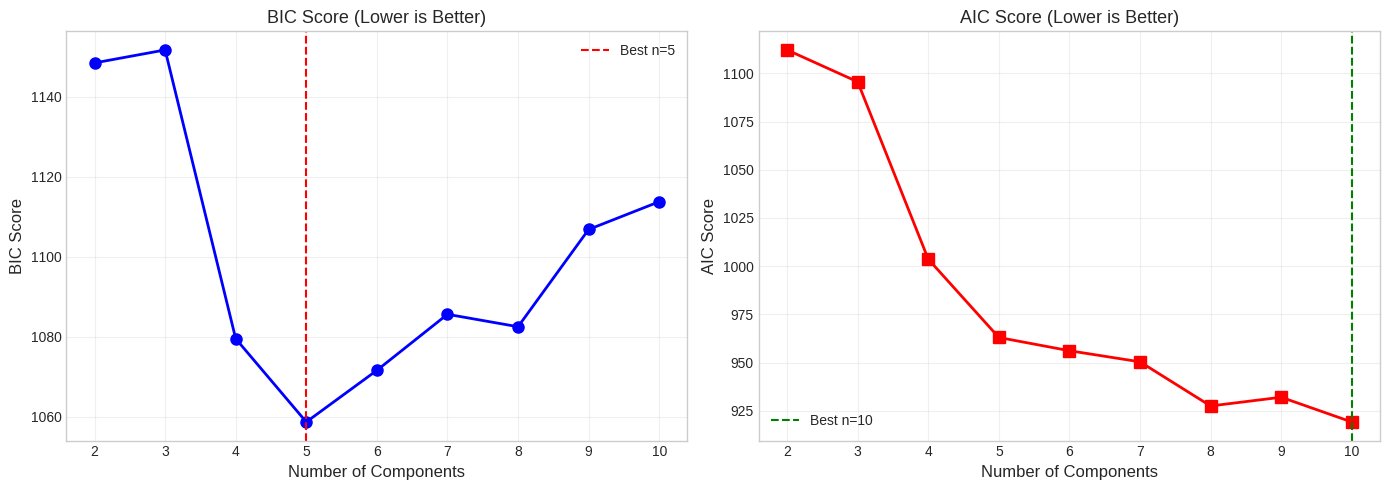

BIC suggests 5 components
AIC suggests 10 components
BIC penalizes model complexity more heavily than AIC
BIC is generally preferred for model selection


In [17]:
# =============================================================================
# 5.3 Gaussian Mixture Model (GMM)
# =============================================================================

# 5.3.1 Model Selection using BIC and AIC
from sklearn.mixture import GaussianMixture

n_components_range = range(2, 11)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=5)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# Plot BIC and AIC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(n_components_range, bic_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('BIC Score', fontsize=12)
axes[0].set_title('BIC Score (Lower is Better)', fontsize=13)
axes[0].set_xticks(list(n_components_range))
axes[0].grid(True, alpha=0.3)
best_bic_n = list(n_components_range)[np.argmin(bic_scores)]
axes[0].axvline(x=best_bic_n, color='red', linestyle='--', label=f'Best n={best_bic_n}')
axes[0].legend()

axes[1].plot(n_components_range, aic_scores, 'rs-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('AIC Score', fontsize=12)
axes[1].set_title('AIC Score (Lower is Better)', fontsize=13)
axes[1].set_xticks(list(n_components_range))
axes[1].grid(True, alpha=0.3)
best_aic_n = list(n_components_range)[np.argmin(aic_scores)]
axes[1].axvline(x=best_aic_n, color='green', linestyle='--', label=f'Best n={best_aic_n}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"BIC suggests {best_bic_n} components")
print(f"AIC suggests {best_aic_n} components")
print("BIC penalizes model complexity more heavily than AIC")
print("BIC is generally preferred for model selection")

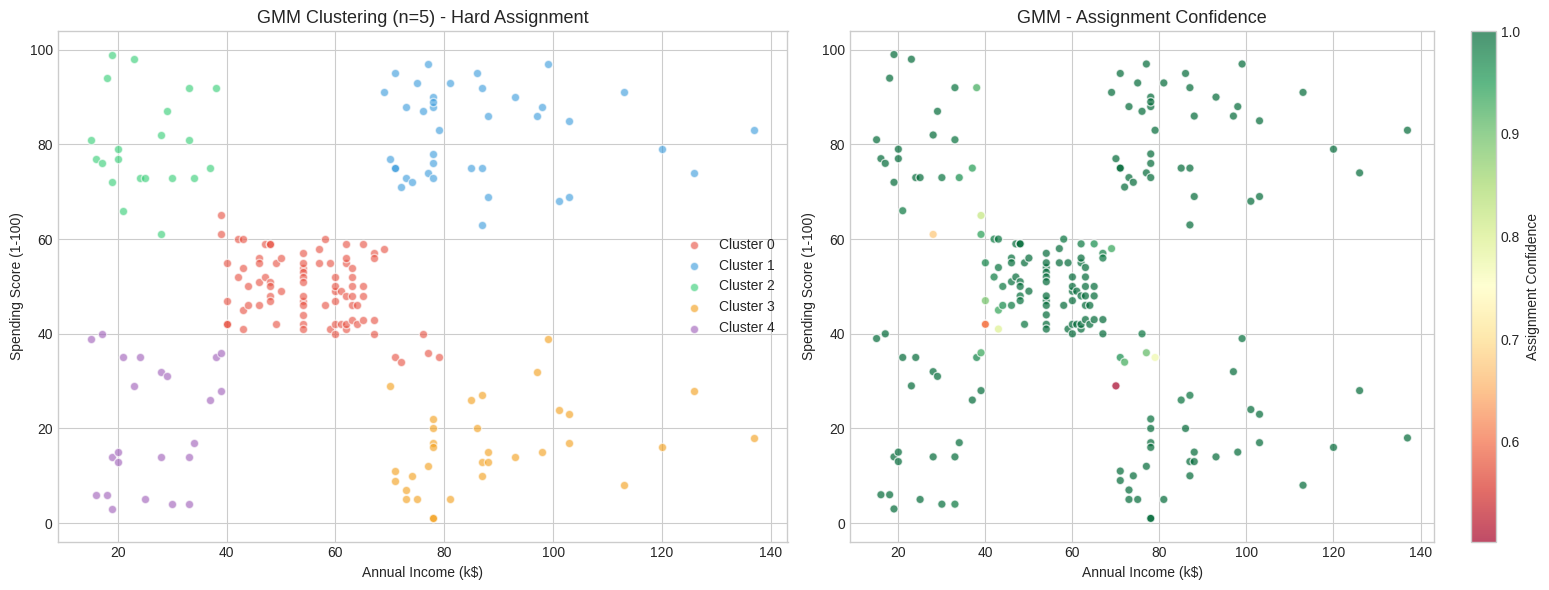

GMM Results:
- Silhouette Score: 0.5537

GMM Cluster Summary:
Cluster 0: n=84, Avg Income=55.6k, Avg Spending=49.4, Confidence=0.973
Cluster 1: n=39, Avg Income=86.5k, Avg Spending=82.1, Confidence=1.000
Cluster 2: n=21, Avg Income=25.1k, Avg Spending=80.0, Confidence=0.973
Cluster 3: n=33, Avg Income=88.8k, Avg Spending=16.0, Confidence=0.984
Cluster 4: n=23, Avg Income=26.3k, Avg Spending=20.9, Confidence=0.994

Key GMM Advantage: Soft clustering provides probability of belonging to each cluster
Points near cluster boundaries have lower confidence scores


In [18]:
# 5.3.2 Final GMM Model (n=5, based on BIC)
gmm_final = GaussianMixture(n_components=5, random_state=42, n_init=5)
gmm_labels = gmm_final.fit_predict(X_scaled)
gmm_probs = gmm_final.predict_proba(X_scaled)

# Silhouette score for GMM
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

# Visualize GMM Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Hard cluster assignments (original scale)
for i in range(5):
    mask = gmm_labels == i
    axes[0].scatter(X.iloc[mask, 0], X.iloc[mask, 1],
                    c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolors='white')
axes[0].set_title('GMM Clustering (n=5) - Hard Assignment', fontsize=13)
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')
axes[0].legend()

# Plot 2: Soft assignment - color by max probability (confidence)
max_probs = gmm_probs.max(axis=1)
scatter = axes[1].scatter(X.iloc[:, 0], X.iloc[:, 1],
                          c=max_probs, cmap='RdYlGn', alpha=0.7, edgecolors='white')
plt.colorbar(scatter, ax=axes[1], label='Assignment Confidence')
axes[1].set_title('GMM - Assignment Confidence', fontsize=13)
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

print(f"GMM Results:")
print(f"- Silhouette Score: {gmm_silhouette:.4f}")
print(f"\nGMM Cluster Summary:")
print("="*60)
for i in range(5):
    mask = gmm_labels == i
    count = mask.sum()
    avg_income = X.iloc[mask, 0].mean()
    avg_spending = X.iloc[mask, 1].mean()
    avg_conf = max_probs[mask].mean()
    print(f"Cluster {i}: n={count}, Avg Income={avg_income:.1f}k, Avg Spending={avg_spending:.1f}, Confidence={avg_conf:.3f}")

print(f"\nKey GMM Advantage: Soft clustering provides probability of belonging to each cluster")
print(f"Points near cluster boundaries have lower confidence scores")

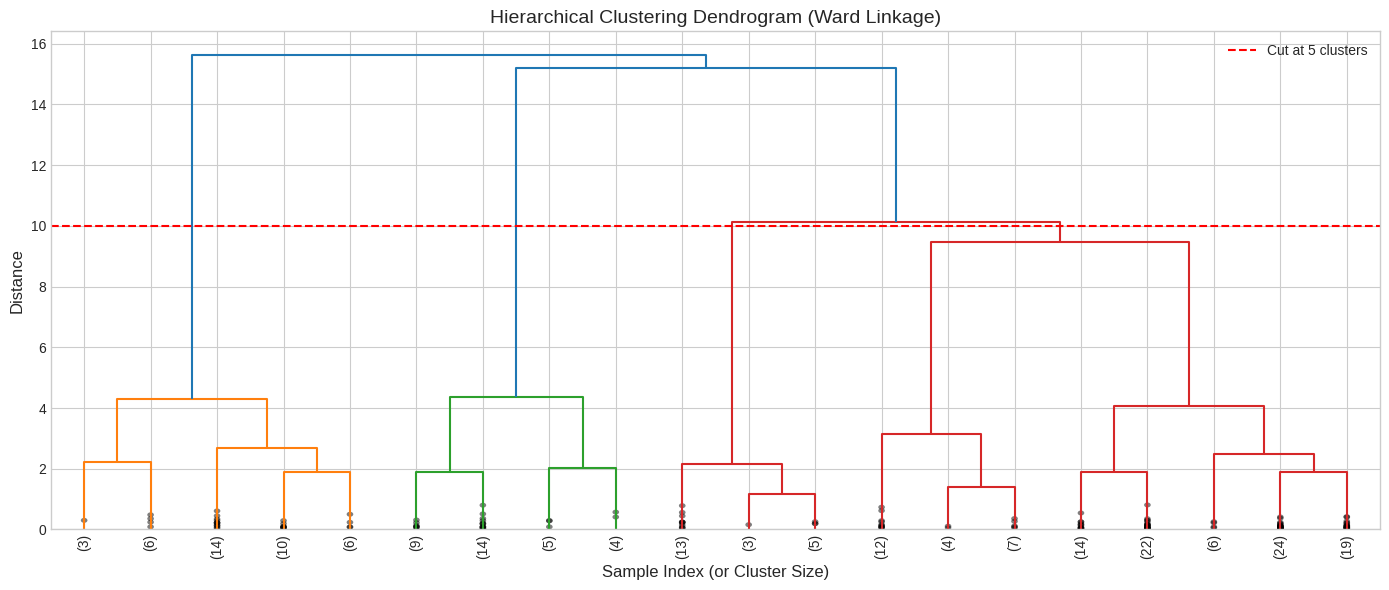

Dendrogram Analysis:
- The red dashed line shows where we cut to get 5 clusters
- Ward linkage minimizes within-cluster variance (similar to K-Means)
- The height of each merge represents the distance between merged clusters


In [19]:
# =============================================================================
# 5.4 Hierarchical Clustering
# =============================================================================

# 5.4.1 Dendrogram
plt.figure(figsize=(14, 6))
linkage_matrix = linkage(X_scaled, method='ward')
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, 
           leaf_rotation=90, leaf_font_size=10,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14)
plt.xlabel('Sample Index (or Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=10, color='red', linestyle='--', label='Cut at 5 clusters')
plt.legend()
plt.tight_layout()
plt.show()

print("Dendrogram Analysis:")
print("- The red dashed line shows where we cut to get 5 clusters")
print("- Ward linkage minimizes within-cluster variance (similar to K-Means)")
print("- The height of each merge represents the distance between merged clusters")

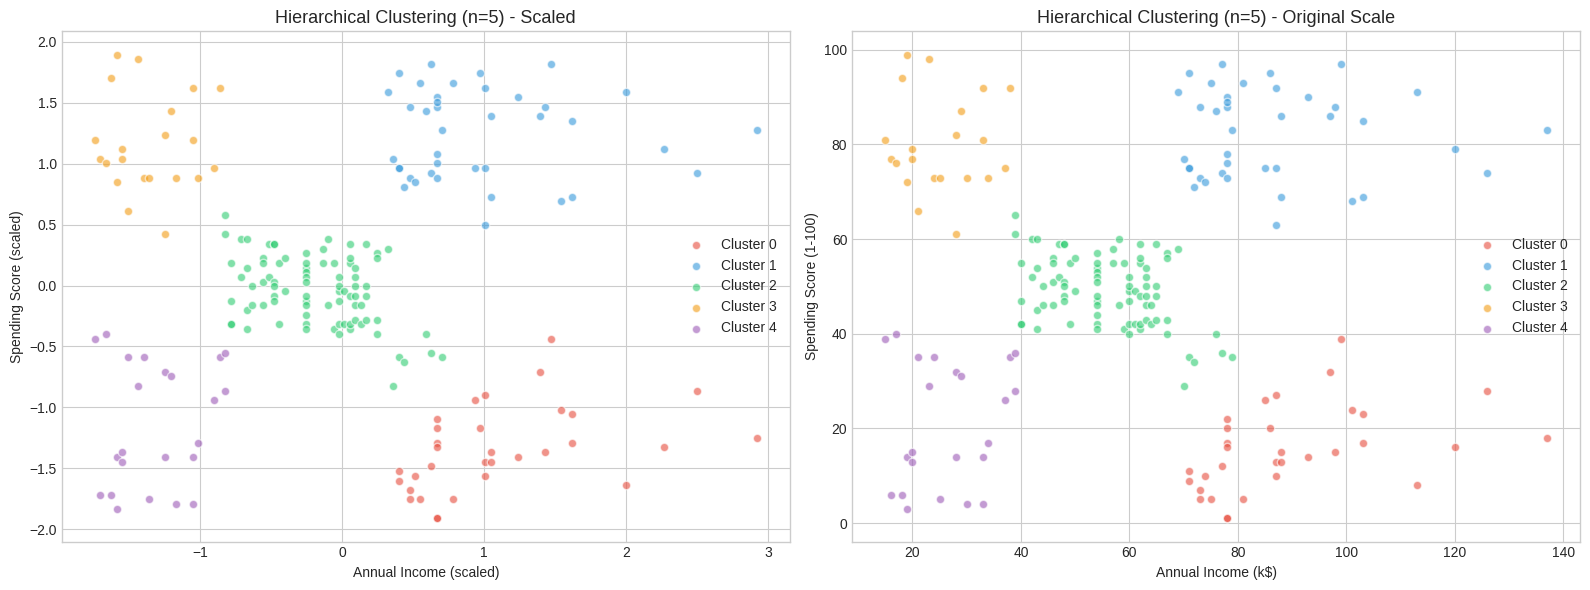

Hierarchical Clustering Results:
- Silhouette Score: 0.5538

Cluster Summary:
Cluster 0: n=32, Avg Income=89.4k, Avg Spending=15.6
Cluster 1: n=39, Avg Income=86.5k, Avg Spending=82.1
Cluster 2: n=85, Avg Income=55.8k, Avg Spending=49.1
Cluster 3: n=21, Avg Income=25.1k, Avg Spending=80.0
Cluster 4: n=23, Avg Income=26.3k, Avg Spending=20.9


In [20]:
# 5.4.2 Final Hierarchical Clustering Model (n=5)
hc_final = AgglomerativeClustering(n_clusters=5, linkage='ward')
hc_labels = hc_final.fit_predict(X_scaled)

hc_silhouette = silhouette_score(X_scaled, hc_labels)

# Visualize Hierarchical Clustering Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scaled
for i in range(5):
    mask = hc_labels == i
    axes[0].scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                    c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolors='white')
axes[0].set_title('Hierarchical Clustering (n=5) - Scaled', fontsize=13)
axes[0].set_xlabel('Annual Income (scaled)')
axes[0].set_ylabel('Spending Score (scaled)')
axes[0].legend()

# Plot 2: Original scale
for i in range(5):
    mask = hc_labels == i
    axes[1].scatter(X.iloc[mask, 0], X.iloc[mask, 1],
                    c=colors[i], label=f'Cluster {i}', alpha=0.6, edgecolors='white')
axes[1].set_title('Hierarchical Clustering (n=5) - Original Scale', fontsize=13)
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Hierarchical Clustering Results:")
print(f"- Silhouette Score: {hc_silhouette:.4f}")
print(f"\nCluster Summary:")
print("="*60)
for i in range(5):
    mask = hc_labels == i
    count = mask.sum()
    avg_income = X.iloc[mask, 0].mean()
    avg_spending = X.iloc[mask, 1].mean()
    print(f"Cluster {i}: n={count}, Avg Income={avg_income:.1f}k, Avg Spending={avg_spending:.1f}")

In [21]:
# =============================================================================
# 6. MODEL COMPARISON
# =============================================================================

# 6.1 Comparison Table
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison_data = {
    'Model': ['K-Means', 'DBSCAN', 'GMM', 'Hierarchical'],
    'Clusters Found': [5, 4, 5, 5],
    'Silhouette Score': [0.5547, 0.6452, 0.5537, 0.5538],
    'Noise Points': ['0 (0%)', '72 (36%)', '0 (0%)', '0 (0%)'],
    'Requires K?': ['Yes', 'No', 'Yes', 'Yes'],
    'Soft Clustering?': ['No', 'No', 'Yes', 'No']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("""
1. CLUSTER AGREEMENT: K-Means, GMM, and Hierarchical all converged on 5 clusters
   with nearly identical silhouette scores (~0.55), validating the cluster structure.

2. DBSCAN LIMITATION: While DBSCAN achieved the highest silhouette score (0.6452),
   it labeled 36% of data as noise - primarily the central "mainstream" customers.
   This makes it less suitable for this dataset where all customers need segmentation.

3. GMM ADVANTAGE: Provides soft clustering with probability assignments.
   This is valuable for customers near cluster boundaries who might respond
   to marketing strategies from multiple segments.

4. RECOMMENDATION: For this customer segmentation task, K-Means or GMM are preferred.
   - K-Means: Simple, interpretable, fast
   - GMM: Better for uncertainty quantification and targeted marketing
""")

MODEL COMPARISON SUMMARY
       Model  Clusters Found  Silhouette Score Noise Points Requires K? Soft Clustering?
     K-Means               5            0.5547       0 (0%)         Yes               No
      DBSCAN               4            0.6452     72 (36%)          No               No
         GMM               5            0.5537       0 (0%)         Yes              Yes
Hierarchical               5            0.5538       0 (0%)         Yes               No

KEY INSIGHTS:

1. CLUSTER AGREEMENT: K-Means, GMM, and Hierarchical all converged on 5 clusters
   with nearly identical silhouette scores (~0.55), validating the cluster structure.

2. DBSCAN LIMITATION: While DBSCAN achieved the highest silhouette score (0.6452),
   it labeled 36% of data as noise - primarily the central "mainstream" customers.
   This makes it less suitable for this dataset where all customers need segmentation.

3. GMM ADVANTAGE: Provides soft clustering with probability assignments.
   This is valuable

CUSTOMER SEGMENT PROFILES (Business Interpretation)
          Age         Annual Income (k$)          Spending Score (1-100)      \
         mean min max               mean min  max                   mean min   
Cluster                                                                        
0        42.7  18  70               55.3  39   76                   49.5  34   
1        32.7  27  40               86.5  69  137                   82.1  63   
2        25.3  18  35               25.7  15   39                   79.4  61   
3        41.1  19  59               88.2  70  137                   17.1   1   
4        45.2  19  67               26.3  15   39                   20.9   3   

              Gender  
        max <lambda>  
Cluster               
0        61     59.3  
1        97     53.8  
2        99     59.1  
3        39     45.7  
4        40     60.9  


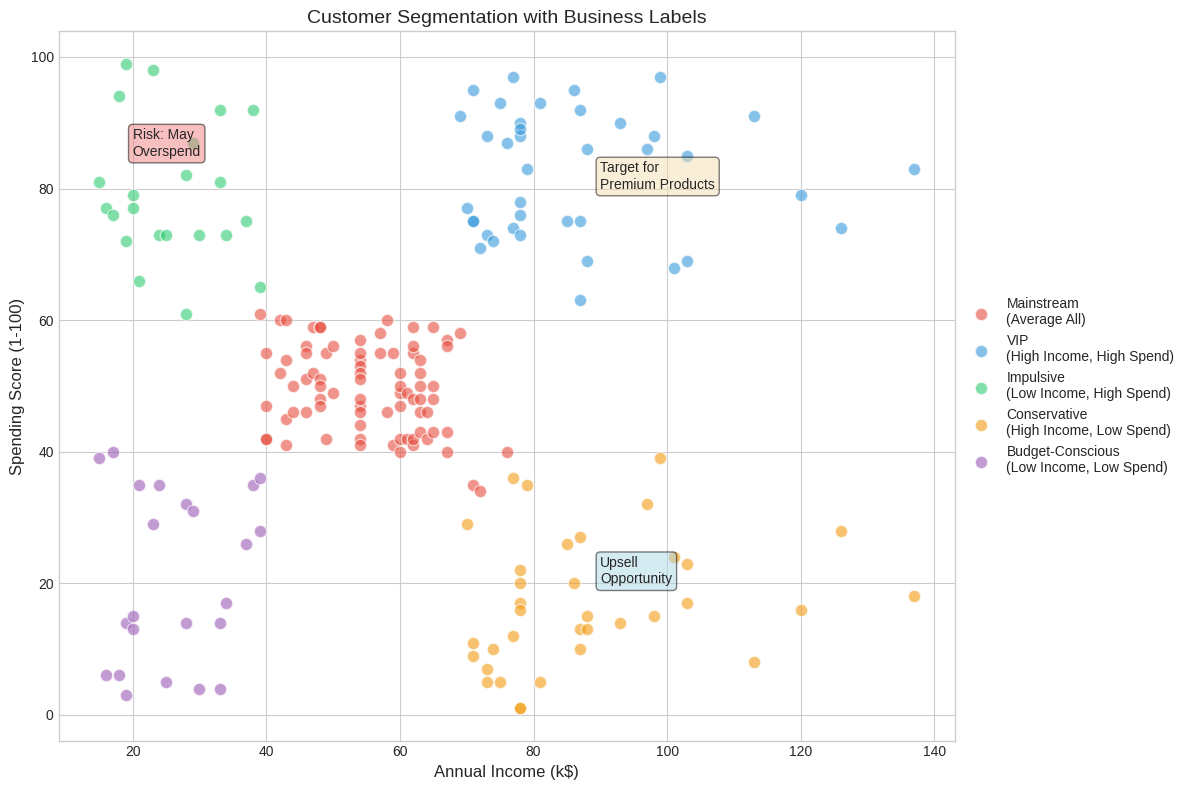

In [22]:
# =============================================================================
# 7. BUSINESS INSIGHTS & RECOMMENDATIONS
# =============================================================================

# 7.1 Final Cluster Profiles (using K-Means as primary model)
df['Cluster'] = kmeans_labels

# Create detailed cluster profiles
print("="*80)
print("CUSTOMER SEGMENT PROFILES (Business Interpretation)")
print("="*80)

cluster_profiles = df.groupby('Cluster').agg({
    'Age': ['mean', 'min', 'max'],
    'Annual Income (k$)': ['mean', 'min', 'max'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Gender': lambda x: (x == 'Female').mean() * 100  # % Female
}).round(1)

print(cluster_profiles)

# 7.2 Visual Summary with Business Labels
fig, ax = plt.subplots(figsize=(12, 8))

cluster_names = {
    0: 'Mainstream\n(Average All)',
    1: 'VIP\n(High Income, High Spend)',
    2: 'Impulsive\n(Low Income, High Spend)',
    3: 'Conservative\n(High Income, Low Spend)',
    4: 'Budget-Conscious\n(Low Income, Low Spend)'
}

for i in range(5):
    mask = kmeans_labels == i
    ax.scatter(X.iloc[mask, 0], X.iloc[mask, 1],
               c=colors[i], label=cluster_names[i], alpha=0.6, 
               edgecolors='white', s=80)

# Add annotations
ax.annotate('Target for\nPremium Products', xy=(90, 80), fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.annotate('Upsell\nOpportunity', xy=(90, 20), fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.annotate('Risk: May\nOverspend', xy=(20, 85), fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

ax.set_xlabel('Annual Income (k$)', fontsize=12)
ax.set_ylabel('Spending Score (1-100)', fontsize=12)
ax.set_title('Customer Segmentation with Business Labels', fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [23]:
# 7.3 Marketing Recommendations
print("="*80)
print("MARKETING RECOMMENDATIONS BY SEGMENT")
print("="*80)

recommendations = """
┌─────────────────────────────────────────────────────────────────────────────┐
│ CLUSTER 0: MAINSTREAM (n=81, 40.5%)                                         │
│ Profile: Middle income (~55k), Average spending (~50), Avg age 43           │
│ Strategy: Standard promotions, loyalty programs, seasonal campaigns         │
│ Channel: Email marketing, social media ads                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│ CLUSTER 1: VIP CUSTOMERS (n=39, 19.5%) ⭐ HIGHEST VALUE                      │
│ Profile: High income (~87k), High spending (~82), Younger (avg 33)          │
│ Strategy: Premium products, exclusive memberships, personal shopping        │
│ Channel: Personal outreach, VIP events, premium app features                │
├─────────────────────────────────────────────────────────────────────────────┤
│ CLUSTER 2: IMPULSIVE BUYERS (n=22, 11%) ⚠️ MONITOR                          │
│ Profile: Low income (~26k), High spending (~79), Youngest (avg 25)          │
│ Strategy: Installment plans, budget tools, responsible spending education   │
│ Channel: Mobile app push notifications, BNPL partnerships                   │
├─────────────────────────────────────────────────────────────────────────────┤
│ CLUSTER 3: CONSERVATIVE WEALTHY (n=35, 17.5%) 📈 GROWTH OPPORTUNITY         │
│ Profile: High income (~88k), Low spending (~17), Avg age 41                 │
│ Strategy: Value demonstration, quality emphasis, investment framing         │
│ Channel: Content marketing, reviews, comparison tools                       │
├─────────────────────────────────────────────────────────────────────────────┤
│ CLUSTER 4: BUDGET-CONSCIOUS (n=23, 11.5%)                                   │
│ Profile: Low income (~26k), Low spending (~21), Oldest (avg 45)             │
│ Strategy: Discounts, clearance, essential products, price matching          │
│ Channel: Promotional emails, discount apps, flyers                          │
└─────────────────────────────────────────────────────────────────────────────┘
"""
print(recommendations)

# 7.4 Summary Statistics
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print(f"""
Dataset: Mall Customer Segmentation (200 customers, 5 features)
Selected Features: Annual Income, Spending Score
Preprocessing: StandardScaler normalization

Models Compared:
  1. K-Means (K=5)      - Silhouette: 0.5547 ✓ Selected
  2. DBSCAN             - Silhouette: 0.6452 (but 36% noise)
  3. GMM (n=5)          - Silhouette: 0.5537 (soft clustering available)
  4. Hierarchical (n=5) - Silhouette: 0.5538

Key Findings:
  • 5 distinct customer segments identified
  • VIP segment (19.5%) drives highest value - priority for retention
  • Conservative wealthy (17.5%) represent untapped potential
  • All three parametric methods converged on same structure
  • DBSCAN unsuitable due to high noise ratio in dense center region

Business Value:
  • Enables targeted marketing campaigns
  • Optimizes resource allocation across segments
  • Identifies at-risk (impulsive) and high-potential (conservative) groups
""")

MARKETING RECOMMENDATIONS BY SEGMENT

┌─────────────────────────────────────────────────────────────────────────────┐
│ CLUSTER 0: MAINSTREAM (n=81, 40.5%)                                         │
│ Profile: Middle income (~55k), Average spending (~50), Avg age 43           │
│ Strategy: Standard promotions, loyalty programs, seasonal campaigns         │
│ Channel: Email marketing, social media ads                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│ CLUSTER 1: VIP CUSTOMERS (n=39, 19.5%) ⭐ HIGHEST VALUE                      │
│ Profile: High income (~87k), High spending (~82), Younger (avg 33)          │
│ Strategy: Premium products, exclusive memberships, personal shopping        │
│ Channel: Personal outreach, VIP events, premium app features                │
├─────────────────────────────────────────────────────────────────────────────┤
│ CLUSTER 2: IMPULSIVE BUYERS (n=22, 11%) ⚠️ MONITOR                          │
│ 